# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.


#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {64, 128, 256, 512, 1024}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.

This might take a while to run, so plan your time carefully.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1.To reduce repeated code, place your

- network (MLP defined in QA1)

- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)
in a separate file called common_utils.py

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# Import the functions from common_utils.py
from common_utils import loss_fn, CustomDataset, intialise_loaders, MLP, preprocess_dataset, EarlyStopper

2.Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [3]:
# Define the function to generate the training and validation datasets for the different batch sizes
def generate_cv_folds_for_batch_sizes(parameters, X_train, y_train):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """
    # Define the number of folds
    no_folds = 5
    
    # Define the dictionaries to store the training and validation datasets
    X_train_scaled_dict = {}
    X_val_scaled_dict = {}
    y_train_dict = {}
    y_val_dict = {}
    
    # Define the k-fold cross-validation
    kf = KFold(n_splits=no_folds, shuffle=True, random_state=0)
    
    # Loop through the different batch sizes
    for batch_size in parameters:
        # Set the initial list value to the dictionaries
        X_train_scaled_dict[batch_size] = []
        X_val_scaled_dict[batch_size] = []
        y_train_dict[batch_size] = []
        y_val_dict[batch_size] = []
        
        # Loop through the different folds
        for train_index, val_index in kf.split(X_train):
            # For every batch size, iterate through the different folds that split the dataset into training and validation datasets
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]  # Split the training and validation datasets with the features
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]  # Split the training and validation datasets with the labels
            
            # Scale the input features
            scaler = preprocessing.StandardScaler()
            X_train_fold = scaler.fit_transform(X_train_fold)
            X_val_fold = scaler.transform(X_val_fold)
            
            # Append the training and validation datasets to the dictionaries
            X_train_scaled_dict[batch_size].append(X_train_fold)
            X_val_scaled_dict[batch_size].append(X_val_fold)
            y_train_dict[batch_size].append(y_train_fold)
            y_val_dict[batch_size].append(y_val_fold)
    
    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

# Custom function to split the dataset for K-Fold Cross Validation, first split then fit the label encoder to the training set and transform the test set
def split_dataset(df, columns_to_drop, test_size, random_state):
    # Split the dataset into training and testing datasets
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # Define the label encoder
    label_encoder = preprocessing.LabelEncoder()

    # Fit and transform the training set, transform the test set
    df_train['label'] = label_encoder.fit_transform(df_train['label'])
    df_test['label'] = label_encoder.transform(df_test['label'])

    # Drop the columns from the training and testing datasets
    df_train2 = df_train.drop(columns_to_drop,axis=1)
    y_train2 = df_train['label'].to_numpy()

    # Drop the columns from the training and testing datasets
    df_test2 = df_test.drop(columns_to_drop,axis=1)
    y_test2 = df_test['label'].to_numpy() 

    return df_train2, y_train2, df_test2, y_test2

# Custom function to preprocess the dataset for K-Fold Cross Validation
def preprocess(df):
    drop_columns = ['filename', 'label']  # Columns to be dropped from the dataframe
    X_train, y_train, X_test, y_test = split_dataset(df, drop_columns, test_size=0.25, random_state=0)  # Split the dataset with test_size=0.25 to achieve 75:25 train-test ratio
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)  # Scale the input features
    return X_train_scaled, y_train, X_test_scaled, y_test


df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

# Define the batch sizes
batch_sizes = [64, 128, 256, 512, 1024]
# Generate the training and validation datasets
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train_scaled, y_train)

In [4]:
# Analyse the shape of the training and validation datasets
for batch_size in batch_sizes:
    print(f'Batch Size: {batch_size}')
    print(f'X_train_scaled_dict[batch_size][0].shape: {X_train_scaled_dict[batch_size][0].shape}')
    print(f'X_val_scaled_dict[batch_size][0].shape: {X_val_scaled_dict[batch_size][0].shape}')
    print(f'y_train_dict[batch_size][0].shape: {y_train_dict[batch_size][0].shape}')
    print(f'y_val_dict[batch_size][0].shape: {y_val_dict[batch_size][0].shape}')
    print()
    

Batch Size: 64
X_train_scaled_dict[batch_size][0].shape: (7233, 77)
X_val_scaled_dict[batch_size][0].shape: (1809, 77)
y_train_dict[batch_size][0].shape: (7233,)
y_val_dict[batch_size][0].shape: (1809,)

Batch Size: 128
X_train_scaled_dict[batch_size][0].shape: (7233, 77)
X_val_scaled_dict[batch_size][0].shape: (1809, 77)
y_train_dict[batch_size][0].shape: (7233,)
y_val_dict[batch_size][0].shape: (1809,)

Batch Size: 256
X_train_scaled_dict[batch_size][0].shape: (7233, 77)
X_val_scaled_dict[batch_size][0].shape: (1809, 77)
y_train_dict[batch_size][0].shape: (7233,)
y_val_dict[batch_size][0].shape: (1809,)

Batch Size: 512
X_train_scaled_dict[batch_size][0].shape: (7233, 77)
X_val_scaled_dict[batch_size][0].shape: (1809, 77)
y_train_dict[batch_size][0].shape: (7233,)
y_val_dict[batch_size][0].shape: (1809,)

Batch Size: 1024
X_train_scaled_dict[batch_size][0].shape: (7233, 77)
X_val_scaled_dict[batch_size][0].shape: (1809, 77)
y_train_dict[batch_size][0].shape: (7233,)
y_val_dict[batch_

3.Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [5]:
# Define the function to find the optimal hyperparameter
def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, parameter_name):
    # Define the dictionaries to store the mean cross-validation accuracies and the time taken to train the network on the last epoch for the different batch sizes
    cross_validation_accuracies = {}
    cross_validation_times = {}
    cross_validation_losses = {}

    # Define the variables from QA1
    no_epochs = 100  # Define the number of epochs
    no_folds = 5  # Define the number of folds
    learning_rate = 0.001  # Learning rate for the optimizer
    patience = 3  # Patience for the early stopper
    no_features = X_train_scaled.shape[1]  # Number of input features
    no_hidden = 128  # Number of neurons in each hidden layer
    no_labels = 1  # Number of output labels
    
    # Loop through the different batch sizes
    for batch_size in batch_sizes:
        # Define the lists to store the cross-validation accuracies, losses and the time taken to train the network on the last epoch for the current batch size
        batch_size_accuracies = []
        batch_size_times = []
        batch_size_losses = []
        # Loop through the different folds
        for fold in range(no_folds):
            # Define the training and validation datasets
            X_train = X_train_scaled_dict[batch_size][fold]
            X_val = X_val_scaled_dict[batch_size][fold]
            y_train = y_train_dict[batch_size][fold]
            y_val = y_val_dict[batch_size][fold]
            
            # Define the dataloaders
            train_dataloader, val_dataloader = intialise_loaders(X_train, y_train, X_val, y_val, batch_size)
            
            # Define the model
            model = MLP(no_features, no_hidden, no_labels)
            
            # Define the optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            
            # Define the early stopper
            early_stopper = EarlyStopper(patience=patience)
            
            # Train the model
            for epoch in range(no_epochs):
                # Start the timer
                start_time = time.time()
                # Set the model to train mode
                model.train()
                # Loop through the mini-batches and train the model
                for X_batch, y_batch in train_dataloader:
                    optimizer.zero_grad()  # Zero the gradients
                    y_pred = model(X_batch)  # Perform a forward pass of the model
                    loss = loss_fn(y_pred, y_batch)  # Compute the loss value between the predictions and the actual target values
                    loss.backward()  # Backpropagate the gradients
                    optimizer.step()  # Update the model parameters
                
                # Set the model to evaluation mode
                model.eval()
                # Define the variables to store the training and validation accuracy and loss values
                val_loss, val_accuracy = 0, 0  # Define variables to store the loss and accuracy values for the test dataset
                test_no_batches = len(val_dataloader)  # Define the number of mini-batches in the test dataset
                test_size = len(val_dataloader.dataset) # Define the size of the dataset
                # Disable gradient computation using the no_grad context, reducing memory consumption
                with torch.no_grad():
                    # Compute the test accuracy and loss
                    for X_batch, y_batch in val_dataloader:
                        y_pred = model(X_batch)  # Perform a forward pass of the model
                        loss = loss_fn(y_pred, y_batch)  # Compute the loss value between the predictions and the actual target values
                        
                        # Compute the test accuracy and loss for the current batch
                        val_loss += loss.item()  # Add the loss value to the running total
                        val_accuracy += ((y_pred > 0.5) == y_batch).sum().item()  # Compute the number of correctly classified samples and add to the running total
                    
                # Compute the average test and test accuracy and loss values
                val_accuracy /= test_size  # Compute the average test accuracy
                val_loss /= test_no_batches  # Compute the average test loss
                    
                if early_stopper.early_stop(val_loss): 
                    end_time = time.time()
                    batch_size_times.append(end_time - start_time)
                    batch_size_accuracies.append(val_accuracy)
                    batch_size_losses.append(val_loss)
                    print(f"Batch size {batch_size}, Fold {fold + 1}, Epoch stopped at {epoch + 1} with validation loss: {val_loss:.4f} and validation accuracy: {val_accuracy:.4f}")
                    break
        
        # Compute the mean cross-validation accuracy, loss and the time taken to train the network on the last epoch for the current batch size
        cross_validation_accuracies[batch_size] = np.mean(batch_size_accuracies)
        cross_validation_times[batch_size] = np.mean(batch_size_times)
        cross_validation_losses[batch_size] = np.mean(batch_size_losses)
        
    # Return the mean cross-validation accuracies, losses and the time taken to train the network on the last epoch for the different batch sizes
    return cross_validation_accuracies, cross_validation_times, cross_validation_losses
        

batch_sizes = [64, 128, 256, 512, 1024]
cross_validation_accuracies, cross_validation_times, cross_validation_losses = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, 'batch_size')


Batch size 64, Fold 1, Epoch stopped at 27 with validation loss: 0.5241 and validation accuracy: 0.7573
Batch size 64, Fold 2, Epoch stopped at 25 with validation loss: 0.5456 and validation accuracy: 0.7341
Batch size 64, Fold 3, Epoch stopped at 26 with validation loss: 0.5380 and validation accuracy: 0.7428
Batch size 64, Fold 4, Epoch stopped at 24 with validation loss: 0.5252 and validation accuracy: 0.7506
Batch size 64, Fold 5, Epoch stopped at 25 with validation loss: 0.5389 and validation accuracy: 0.7373
Batch size 128, Fold 1, Epoch stopped at 25 with validation loss: 0.5110 and validation accuracy: 0.7595
Batch size 128, Fold 2, Epoch stopped at 22 with validation loss: 0.5319 and validation accuracy: 0.7341
Batch size 128, Fold 3, Epoch stopped at 26 with validation loss: 0.5473 and validation accuracy: 0.7362
Batch size 128, Fold 4, Epoch stopped at 21 with validation loss: 0.5516 and validation accuracy: 0.7268
Batch size 128, Fold 5, Epoch stopped at 19 with validation 

4.Plot scatterplot of mean cross validation accuracies for the different batch sizes.

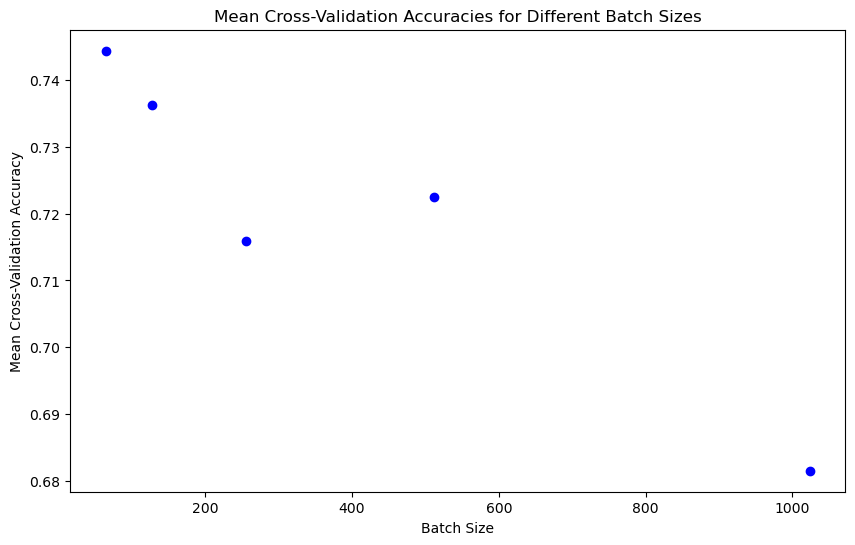

In [6]:
# Plot the scatterplot of mean cross-validation accuracies for the different batch sizes
plt.figure(figsize=(10, 6))
plt.scatter(cross_validation_accuracies.keys(), cross_validation_accuracies.values(), color='blue')
plt.title('Mean Cross-Validation Accuracies for Different Batch Sizes')
plt.xlabel('Batch Size')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.show()

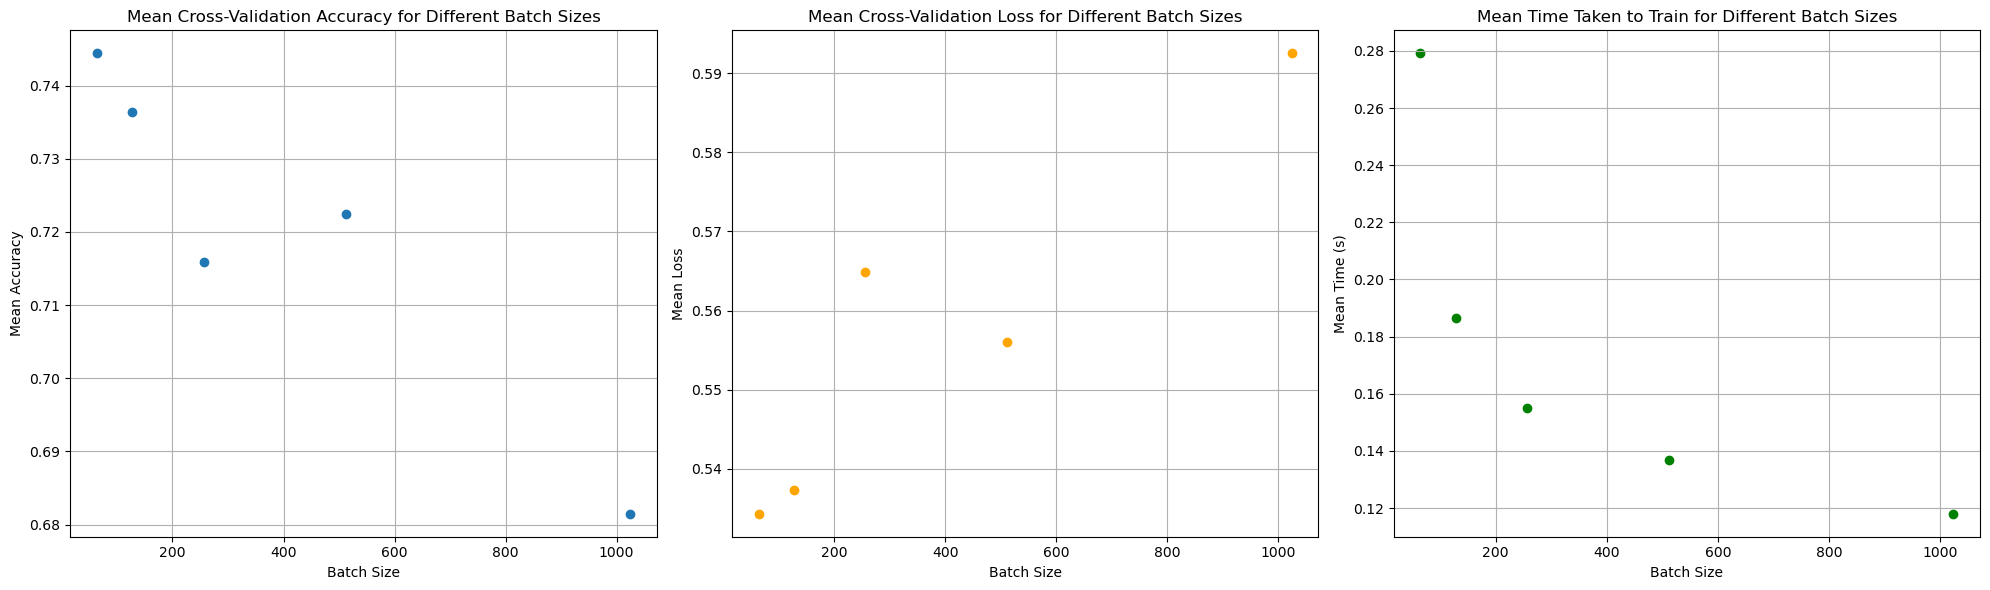

In [7]:
# Plot the 3 plots for the mean cross-validation accuracies, losses and the time taken to train the network on the last epoch for the different batch sizes
plt.figure(figsize=(20, 6))

# Plot mean cross-validation accuracy for different batch sizes
plt.subplot(1, 3, 1)
plt.scatter(list(cross_validation_accuracies.keys()), list(cross_validation_accuracies.values()), marker='o')
plt.title('Mean Cross-Validation Accuracy for Different Batch Sizes')
plt.xlabel('Batch Size')
plt.ylabel('Mean Accuracy')
plt.grid(True)

# Plot mean cross-validation loss for different batch sizes
plt.subplot(1, 3, 2)
plt.scatter(list(cross_validation_losses.keys()), list(cross_validation_losses.values()), marker='o', color='orange')
plt.title('Mean Cross-Validation Loss for Different Batch Sizes')
plt.xlabel('Batch Size')
plt.ylabel('Mean Loss')
plt.grid(True)

# Plot mean time taken to train for different batch sizes
plt.subplot(1, 3, 3)
plt.scatter(list(cross_validation_times.keys()), list(cross_validation_times.values()), marker='o', color='green')
plt.title('Mean Time Taken to Train for Different Batch Sizes')
plt.xlabel('Batch Size')
plt.ylabel('Mean Time (s)')
plt.grid(True)

plt.tight_layout()
plt.show()


4.Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [8]:
df = pd.DataFrame({'Batch Size': cross_validation_times.keys(), # Get the batch sizes from the dictionary's keys
                   'Last Epoch Time': cross_validation_times.values(), # Get the time taken to train the network on the last epoch from the dictionary's values
                    'Mean Cross-Validation Accuracy': cross_validation_accuracies.values(), # Get the mean cross-validation accuracy from the dictionary's values
                    'Mean Cross-Validation Loss': cross_validation_losses.values() # Get the mean cross-validation loss from the dictionary's values
                  })

df

,Batch Size,Last Epoch Time,Mean Cross-Validation Accuracy,Mean Cross-Validation Loss
0,64,0.279147,0.744415,0.534345
1,128,0.186541,0.736339,0.537388
2,256,0.154873,0.715880,0.564864
3,512,0.136919,0.722517,0.556073
4,1024,0.118028,0.681487,0.592502


In [9]:
# Calculating the differance (in percents) between the statistics for batch size 64 and 128
print(f"Mean Cross-Validation Accuracy difference between batch size 64 and 128: {abs(cross_validation_accuracies[64] - cross_validation_accuracies[128]) / cross_validation_accuracies[64] * 100:.2f}%")
print(f"Mean Cross-Validation Loss difference between batch size 64 and 128: {abs(cross_validation_losses[64] - cross_validation_losses[128]) / cross_validation_losses[64] * 100:.2f}%")
print(f"Mean Time Taken to Train difference between batch size 64 and 128: {abs(cross_validation_times[64] - cross_validation_times[128]) / cross_validation_times[64] * 100:.2f}%")

Mean Cross-Validation Accuracy difference between batch size 64 and 128: 1.08%
Mean Cross-Validation Loss difference between batch size 64 and 128: 0.57%
Mean Time Taken to Train difference between batch size 64 and 128: 33.17%


In [10]:
# Select the optimal batch size
optimal_batch_size = 128 
reason = """
Despite the fact that the batch size of 64 has the highest mean cross-validation accuracy and lowest loss, the time taken to train the network on the last epoch is significantly higher than the batch size of 128. The batch size of 128 has the second highest mean cross-validation accuracy and second lowest loss, and much lower time taken to train the network on the last epoch. Also, the difference in the performance (accuracy and loss) are around 1%, while the time difference is ~30% of the time for batch size 64. As we also consider efficiency and time, batch size of 128 performs similarly with much less time needed. Therefore, the batch size of 128 is the optimal batch size for mini-batch gradient descent.
"""